In [2]:
library(rJava)
source("https://bioconductor.org/biocLite.R")
# biocLite("org.Hs.eg.db")
biocLite("RDAVIDWebService")

Bioconductor version 3.4 (BiocInstaller 1.24.0), ?biocLite for help
BioC_mirror: https://bioconductor.org
Using Bioconductor 3.4 (BiocInstaller 1.24.0), R 3.3.2 (2016-10-31).
Installing package(s) ‘RDAVIDWebService’
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Old packages: 'AnnotationHub', 'backports', 'broom', 'cluster', 'colorspace',
  'data.table', 'DBI', 'digest', 'forcats', 'ggplot2', 'IRanges', 'jsonlite',
  'Matrix', 'mgcv', 'nlme', 'openssl', 'pbdZMQ', 'pbkrtest', 'psych', 'Rcpp',
  'RcppEigen', 'readr', 'rprojroot', 'S4Vectors', 'selectr', 'shiny',
  'SparseM', 'stringi', 'stringr', 'survival', 'tidyr', 'tidyverse', 'xml2',
  'XVector', 'zoo'


In [1]:
#libraries
library(GO.db)
library(topGO)
library(org.Hs.eg.db)
library(org.Sc.sgd.db)
library(GOSemSim)

Loading required package: AnnotationDbi
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colnames, do.call,
    duplicated, eval, evalq, Filter, Find, get, grep, grepl, intersect,
    is.unsorted, lapply, lengths, Map, mapply, match, mget, order,
    paste, pmax, pmax.int, pmin, pmin.int, Position, rank, rbind,
    Reduce, rownames, sapply, setdiff, sort, table, tapply, union,
    unique, unsplit, which, which.max, which.min

Loading required package: Biobase
Welcome to Bioconductor

 

In [10]:
file <- "Uetz_screen"

p <- "1.0"
init <- 60

db <- org.Sc.sgd.db
mapping <- "org.Sc.sgd.db"
ID <- "ENSEMBL"
# db <- org.Hs.eg.db
# mapping <- "org.Hs.eg.db"
# ID <- "ENTREZ"

In [11]:
#background gene list
setwd('/home/david/Documents/ghsom')
allGenes <- scan(sprintf("%s.txt", file), character())
allGenes <- unique(allGenes) 
length(allGenes)

[1] 806

In [12]:
##load all community gene lists
setwd(sprintf("/home/david/Documents/ghsom/uetz_communities_%s_%s", p, init))
# setwd("/home/david/Documents/ghsom/union_communities_08")
# setwd("/home/david/Documents/ghsom/hi_communities_08")

g <- list()
numCom <- 0
filename <- sprintf("community_%s.txt", numCom)
while (file.exists(filename)) {
    numCom <- numCom + 1
    g[[numCom]] <- scan(filename, character())
    filename <- sprintf("community_%s.txt", numCom)
}
numCom

[1] 33

In [13]:
#distances between neurons
shortest.path <- read.csv("shortest_path.csv", sep=",", header=FALSE)

In [14]:
cutOff <- 0.05

filename <- sprintf("%s-%s-%s.rda", file, p, cutOff)

if (file.exists(filename)){
    
    print(sprintf("loading: %s", filename))
    load(filename)
    print("loaded")
    
} else {
    
    print("creating topGO objects")

    geneLists <- vector("list", numCom) 
    GOdataObjects <- vector("list", numCom) 
    resultFishers <- vector("list", numCom) 
    results <- vector("list", numCom) 
    gos <- vector("list", numCom) 

    #perform enrichment analyses
    for (c in 1:numCom){

        #factor of interesting genes
        geneList <- factor(as.integer(allGenes %in% g[[c]]))
        names(geneList) <- allGenes
        geneLists[[c]] <- geneList

        #construct topGO object
        GOdata <- new("topGOdata", description=sprintf("topGO object for community %s", c),
                      ontology = "BP", allGenes = geneList,
                      annotationFun = annFUN.org, mapping = mapping, 
                      ID = ID, nodeSize = 10)
        GOdataObjects[[c]] <- GOdata

        #fishers exact test classic
        resultFisher <- runTest(GOdata, algorithm = "classic", statistic = "fisher")
        resultFishers[[c]] <- resultFisher

        #tabulate results
        allRes <- GenTable(GOdata, classicFisher = resultFisher,
                      orderBy = "classicFisher", topNodes = 500)
        results[[c]] <- allRes

        #go terms < cut off 
        gos[[c]] <- score(resultFisher)[score(resultFisher) < cutOff]

        print(sprintf("community %s complete", c))
    }
    
    print(sprintf("Saving data: %s", filename))
    save(geneLists, GOdataObjects, resultFishers, results, gos, file=filename)
    print("saved")
}

[1] "creating topGO objects"



Building most specific GOs .....
	( 1106 GO terms found. )

Build GO DAG topology ..........
	( 2835 GO terms and 6413 relations. )

Annotating nodes ...............
	( 770 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 230 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "community 1 complete"



Building most specific GOs .....
	( 1106 GO terms found. )

Build GO DAG topology ..........
	( 2835 GO terms and 6413 relations. )

Annotating nodes ...............
	( 770 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 130 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "community 2 complete"



Building most specific GOs .....
	( 1106 GO terms found. )

Build GO DAG topology ..........
	( 2835 GO terms and 6413 relations. )

Annotating nodes ...............
	( 770 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 228 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "community 3 complete"



Building most specific GOs .....
	( 1106 GO terms found. )

Build GO DAG topology ..........
	( 2835 GO terms and 6413 relations. )

Annotating nodes ...............
	( 770 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 184 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "community 4 complete"



Building most specific GOs .....
	( 1106 GO terms found. )

Build GO DAG topology ..........
	( 2835 GO terms and 6413 relations. )

Annotating nodes ...............
	( 770 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 213 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "community 5 complete"



Building most specific GOs .....
	( 1106 GO terms found. )

Build GO DAG topology ..........
	( 2835 GO terms and 6413 relations. )

Annotating nodes ...............
	( 770 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 180 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "community 6 complete"



Building most specific GOs .....
	( 1106 GO terms found. )

Build GO DAG topology ..........
	( 2835 GO terms and 6413 relations. )

Annotating nodes ...............
	( 770 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 218 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "community 7 complete"



Building most specific GOs .....
	( 1106 GO terms found. )

Build GO DAG topology ..........
	( 2835 GO terms and 6413 relations. )

Annotating nodes ...............
	( 770 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 138 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "community 8 complete"



Building most specific GOs .....
	( 1106 GO terms found. )

Build GO DAG topology ..........
	( 2835 GO terms and 6413 relations. )

Annotating nodes ...............
	( 770 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 241 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "community 9 complete"



Building most specific GOs .....
	( 1106 GO terms found. )

Build GO DAG topology ..........
	( 2835 GO terms and 6413 relations. )

Annotating nodes ...............
	( 770 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 208 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "community 10 complete"



Building most specific GOs .....
	( 1106 GO terms found. )

Build GO DAG topology ..........
	( 2835 GO terms and 6413 relations. )

Annotating nodes ...............
	( 770 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 107 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "community 11 complete"



Building most specific GOs .....
	( 1106 GO terms found. )

Build GO DAG topology ..........
	( 2835 GO terms and 6413 relations. )

Annotating nodes ...............
	( 770 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 108 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "community 12 complete"



Building most specific GOs .....
	( 1106 GO terms found. )

Build GO DAG topology ..........
	( 2835 GO terms and 6413 relations. )

Annotating nodes ...............
	( 770 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 219 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "community 13 complete"



Building most specific GOs .....
	( 1106 GO terms found. )

Build GO DAG topology ..........
	( 2835 GO terms and 6413 relations. )

Annotating nodes ...............
	( 770 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 199 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "community 14 complete"



Building most specific GOs .....
	( 1106 GO terms found. )

Build GO DAG topology ..........
	( 2835 GO terms and 6413 relations. )

Annotating nodes ...............
	( 770 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 215 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "community 15 complete"



Building most specific GOs .....
	( 1106 GO terms found. )

Build GO DAG topology ..........
	( 2835 GO terms and 6413 relations. )

Annotating nodes ...............
	( 770 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 125 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "community 16 complete"



Building most specific GOs .....
	( 1106 GO terms found. )

Build GO DAG topology ..........
	( 2835 GO terms and 6413 relations. )

Annotating nodes ...............
	( 770 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 283 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "community 17 complete"



Building most specific GOs .....
	( 1106 GO terms found. )

Build GO DAG topology ..........
	( 2835 GO terms and 6413 relations. )

Annotating nodes ...............
	( 770 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 160 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "community 18 complete"



Building most specific GOs .....
	( 1106 GO terms found. )

Build GO DAG topology ..........
	( 2835 GO terms and 6413 relations. )

Annotating nodes ...............
	( 770 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 211 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "community 19 complete"



Building most specific GOs .....
	( 1106 GO terms found. )

Build GO DAG topology ..........
	( 2835 GO terms and 6413 relations. )

Annotating nodes ...............
	( 770 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 52 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "community 20 complete"



Building most specific GOs .....
	( 1106 GO terms found. )

Build GO DAG topology ..........
	( 2835 GO terms and 6413 relations. )

Annotating nodes ...............
	( 770 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 104 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "community 21 complete"



Building most specific GOs .....
	( 1106 GO terms found. )

Build GO DAG topology ..........
	( 2835 GO terms and 6413 relations. )

Annotating nodes ...............
	( 770 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 195 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "community 22 complete"



Building most specific GOs .....
	( 1106 GO terms found. )

Build GO DAG topology ..........
	( 2835 GO terms and 6413 relations. )

Annotating nodes ...............
	( 770 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 136 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "community 23 complete"



Building most specific GOs .....
	( 1106 GO terms found. )

Build GO DAG topology ..........
	( 2835 GO terms and 6413 relations. )

Annotating nodes ...............
	( 770 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 246 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "community 24 complete"



Building most specific GOs .....
	( 1106 GO terms found. )

Build GO DAG topology ..........
	( 2835 GO terms and 6413 relations. )

Annotating nodes ...............
	( 770 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 216 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "community 25 complete"



Building most specific GOs .....
	( 1106 GO terms found. )

Build GO DAG topology ..........
	( 2835 GO terms and 6413 relations. )

Annotating nodes ...............
	( 770 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 206 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "community 26 complete"



Building most specific GOs .....
	( 1106 GO terms found. )

Build GO DAG topology ..........
	( 2835 GO terms and 6413 relations. )

Annotating nodes ...............
	( 770 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 156 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "community 27 complete"



Building most specific GOs .....
	( 1106 GO terms found. )

Build GO DAG topology ..........
	( 2835 GO terms and 6413 relations. )

Annotating nodes ...............
	( 770 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 95 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "community 28 complete"



Building most specific GOs .....
	( 1106 GO terms found. )

Build GO DAG topology ..........
	( 2835 GO terms and 6413 relations. )

Annotating nodes ...............
	( 770 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 191 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "community 29 complete"



Building most specific GOs .....
	( 1106 GO terms found. )

Build GO DAG topology ..........
	( 2835 GO terms and 6413 relations. )

Annotating nodes ...............
	( 770 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 182 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "community 30 complete"



Building most specific GOs .....
	( 1106 GO terms found. )

Build GO DAG topology ..........
	( 2835 GO terms and 6413 relations. )

Annotating nodes ...............
	( 770 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 169 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "community 31 complete"



Building most specific GOs .....
	( 1106 GO terms found. )

Build GO DAG topology ..........
	( 2835 GO terms and 6413 relations. )

Annotating nodes ...............
	( 770 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 153 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "community 32 complete"



Building most specific GOs .....
	( 1106 GO terms found. )

Build GO DAG topology ..........
	( 2835 GO terms and 6413 relations. )

Annotating nodes ...............
	( 770 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 112 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "community 33 complete"
[1] "Saving data: Uetz_screen-1.0-0.05.rda"
[1] "saved"


In [15]:
##SEMATIC SIMILARITY
#construct gosemsim object
semsimfile <- sprintf("%s-semsimfile.rda", file)
if (file.exists(semsimfile)){
    print(sprintf("loading: %s", semsimfile))
    load(semsimfile)
    print("loaded")
} else {
    print(sprintf("creating %s", semsimfile))
    hsGO <- godata(mapping, ont="BP", keytype=ID)
    save(hsGO, file=semsimfile)
    print(sprintf("saved semsimfile: %s", semsimfile))
}


[1] "creating Uetz_screen-semsimfile.rda"
[1] "preparing gene to GO mapping data..."
[1] "preparing IC data..."
[1] "saved semsimfile: Uetz_screen-semsimfile.rda"


In [16]:
information_content <- function(term){
    return (goSim(term, term, semData=hsGO, measure="Resnik"))
}

In [17]:
most_representative_term_ic <- function(namedTerms){
    ics <- sapply(names(namedTerms), information_content)
    names(ics) <- names(namedTerms)
    return(names(sort(ics, decreasing=TRUE)[1]))
}

In [18]:
most_representative_term_ancestor <- function(namedTerms){
    
    counts <- numeric(length(namedTerms))
    names(counts) <- names(namedTerms)

    for (term in names(namedTerms)) {
        ancestors <- as.list(GOBPANCESTOR[term])
        for (ancestor in ancestors[[term]]) {
            if (ancestor %in% names(counts)) {
                counts[ancestor] <- counts[ancestor] + 1
            }
        }

    }
#     return (sort(names(counts), decreasing=TRUE)[1])
    return (names(sort(counts / sum(counts), decreasing=TRUE)[1]))
}

In [19]:
sapply(gos, function(g){length(g)})

[1]  8 31 35 16  4  5 28  0 14  6 25 22  9  3 34 11 16 15 35  9 13 48 39 54 11
[26] 28 38 26  2 17  0  2 16

In [20]:
representativeTermsAncestor <- sapply(Filter(length, gos), most_representative_term_ancestor)

In [21]:
representativeTermsAncestor <-representativeTermsAncestor[!is.na(representativeTermsAncestor)] 

In [22]:
representativeTermsAncestor

[1] "GO:0051179" "GO:0006725" "GO:0051179" "GO:0022411" "GO:0008380"
 [6] "GO:0007059" "GO:0051726" "GO:0006259" "GO:0042592" "GO:0007049"
[11] "GO:0051234" "GO:0009892" "GO:0009891" "GO:0000003" "GO:0065008"
[16] "GO:0044710" "GO:0006725" "GO:0051179" "GO:0009057" "GO:0009056"
[21] "GO:0043170" "GO:0051641" "GO:0050789" "GO:0071554" "GO:0042325"
[26] "GO:0006807" "GO:0040007" "GO:0044087" "GO:0000003" "GO:0009056"

In [23]:
representativeTermsIC <- sapply(Filter(length, gos), most_representative_term_ic)

In [24]:
representativeTermsIC

[1] "GO:0032880" "GO:0000288" "GO:0006997" "GO:0000422" "GO:0000398"
 [6] "GO:0006302" "GO:0017148" "GO:0006312" "GO:0000723" "GO:0046785"
[11] "GO:0007031" "GO:0000122" "GO:0000122" "GO:0007131" "GO:0030003"
[16] "GO:0043094" "GO:0018205" "GO:0031503" "GO:0006511" "GO:0017148"
[21] "GO:0051123" "GO:0051123" "GO:0031577" "GO:0031505" "GO:0030242"
[26] "GO:0000288" "GO:0001403" "GO:0043254" "GO:0006323" "GO:1901565"
[31] "GO:0000956"

In [25]:
select(GO.db, keys=representativeTermsAncestor, columns=c("TERM", "DEFINITION"))

'select()' returned many:1 mapping between keys and columns


GOID,TERM,DEFINITION
GO:0051179,localization,"Any process in which a cell, a substance, or a cellular entity, such as a protein complex or organelle, is transported, tethered to or otherwise maintained in a specific location. In the case of substances, localization may also be achieved via selective degradation."
GO:0006725,cellular aromatic compound metabolic process,"The chemical reactions and pathways involving aromatic compounds, any organic compound characterized by one or more planar rings, each of which contains conjugated double bonds and delocalized pi electrons, as carried out by individual cells."
GO:0051179,localization,"Any process in which a cell, a substance, or a cellular entity, such as a protein complex or organelle, is transported, tethered to or otherwise maintained in a specific location. In the case of substances, localization may also be achieved via selective degradation."
GO:0022411,cellular component disassembly,A cellular process that results in the breakdown of a cellular component.
GO:0008380,RNA splicing,The process of removing sections of the primary RNA transcript to remove sequences not present in the mature form of the RNA and joining the remaining sections to form the mature form of the RNA.
GO:0007059,chromosome segregation,"The process in which genetic material, in the form of chromosomes, is organized into specific structures and then physically separated and apportioned to two or more sets. In eukaryotes, chromosome segregation begins with the condensation of chromosomes, includes chromosome separation, and ends when chromosomes have completed movement to the spindle poles."
GO:0051726,regulation of cell cycle,Any process that modulates the rate or extent of progression through the cell cycle.
GO:0006259,DNA metabolic process,"Any cellular metabolic process involving deoxyribonucleic acid. This is one of the two main types of nucleic acid, consisting of a long, unbranched macromolecule formed from one, or more commonly, two, strands of linked deoxyribonucleotides."
GO:0042592,homeostatic process,Any biological process involved in the maintenance of an internal steady state.
GO:0007049,cell cycle,"The progression of biochemical and morphological phases and events that occur in a cell during successive cell replication or nuclear replication events. Canonically, the cell cycle comprises the replication and segregation of genetic material followed by the division of the cell, but in endocycles or syncytial cells nuclear replication or nuclear division may not be followed by cell division."


In [26]:
simsGOAncestor <- mgoSim(representativeTermsAncestor, representativeTermsAncestor, semData=hsGO, measure="Resnik", combine=NULL)

In [27]:
head(simsGOAncestor)

,GO:0051179,GO:0006725,GO:0022411,GO:0008380,GO:0007059,GO:0051726,GO:0006259,GO:0042592,GO:0007049,GO:0051234,⋯,GO:0009057,GO:0009056,GO:0043170,GO:0051641,GO:0050789,GO:0071554,GO:0042325,GO:0006807,GO:0040007,GO:0044087
GO:0051179,0.165,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.165,⋯,0.000,0.000,0.000,0.165,0.000,0.000,0.000,0.000,0,0.000
GO:0006725,0.000,0.128,0.031,0.128,0.031,0.031,0.128,0.000,0.031,0.000,⋯,0.063,0.063,0.063,0.000,0.000,0.031,0.075,0.063,0,0.000
GO:0022411,0.000,0.031,0.491,0.031,0.116,0.116,0.031,0.000,0.116,0.000,⋯,0.000,0.000,0.000,0.000,0.000,0.031,0.031,0.000,0,0.152
GO:0008380,0.000,0.128,0.031,0.422,0.031,0.031,0.141,0.000,0.031,0.000,⋯,0.096,0.063,0.096,0.000,0.000,0.031,0.075,0.107,0,0.000
GO:0007059,0.000,0.031,0.116,0.031,0.404,0.116,0.031,0.000,0.116,0.000,⋯,0.000,0.000,0.000,0.000,0.000,0.031,0.031,0.000,0,0.000
GO:0051726,0.000,0.031,0.116,0.031,0.116,0.420,0.031,0.171,0.261,0.000,⋯,0.000,0.000,0.000,0.000,0.184,0.031,0.189,0.000,0,0.184


In [28]:
simsGOIC <- mgoSim(representativeTermsIC, representativeTermsIC, semData=hsGO, measure="Resnik", combine=NULL)

In [29]:
head(simsGOIC)

,GO:0032880,GO:0000288,GO:0006997,GO:0000422,GO:0000398,GO:0006302,GO:0017148,GO:0006312,GO:0000723,GO:0046785,⋯,GO:0006511,GO:0051123,GO:0031577,GO:0031505,GO:0030242,GO:0001403,GO:0043254,GO:0006323,GO:1901565,GO:0000956
GO:0032880,0.598,0.000,0.000,0.000,0.000,0.000,0.184,0.000,0.171,0.000,⋯,0.000,0.000,0.000,0.000,0.000,0.000,0.184,0.000,0.000,0.000
GO:0000288,0.000,0.548,0.031,0.031,0.350,0.141,0.115,0.141,0.141,0.031,⋯,0.337,0.167,0.031,0.031,0.031,0.000,0.031,0.031,0.292,0.462
GO:0006997,0.000,0.031,0.556,0.224,0.031,0.031,0.031,0.031,0.224,0.224,⋯,0.031,0.171,0.031,0.171,0.224,0.000,0.171,0.224,0.000,0.031
GO:0000422,0.000,0.031,0.224,0.658,0.031,0.031,0.031,0.031,0.224,0.328,⋯,0.031,0.171,0.116,0.171,0.425,0.098,0.171,0.224,0.000,0.031
GO:0000398,0.000,0.350,0.031,0.031,0.475,0.141,0.155,0.141,0.141,0.031,⋯,0.102,0.167,0.031,0.031,0.031,0.000,0.031,0.031,0.107,0.350
GO:0006302,0.000,0.141,0.031,0.031,0.141,0.482,0.115,0.279,0.279,0.031,⋯,0.102,0.141,0.031,0.031,0.031,0.000,0.031,0.031,0.107,0.141


In [30]:
head(shortest.path)

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33
0.000000e+00,-9.223372e+18,-9.223372e+18,-9.223372e+18,-9.223372e+18,-9.223372e+18,-9.223372e+18,-9.223372e+18,-9.223372e+18,-9.223372e+18,⋯,-9.223372e+18,-9.223372e+18,-9.223372e+18,-9.223372e+18,-9.223372e+18,-9.223372e+18,-9.223372e+18,-9.223372e+18,-9.223372e+18,-9.223372e+18
-9.223372e+18,0.000000e+00,3.000000e+00,-9.223372e+18,-9.223372e+18,1.000000e+00,2.000000e+00,3.000000e+00,-9.223372e+18,-9.223372e+18,⋯,9.000000e+00,-9.223372e+18,-9.223372e+18,1.000000e+01,1.000000e+01,-9.223372e+18,-9.223372e+18,1.100000e+01,1.100000e+01,1.100000e+01
-9.223372e+18,3.000000e+00,0.000000e+00,-9.223372e+18,-9.223372e+18,2.000000e+00,1.000000e+00,1.000000e+00,-9.223372e+18,-9.223372e+18,⋯,7.000000e+00,-9.223372e+18,-9.223372e+18,8.000000e+00,8.000000e+00,-9.223372e+18,-9.223372e+18,9.000000e+00,9.000000e+00,9.000000e+00
-9.223372e+18,-9.223372e+18,-9.223372e+18,0.000000e+00,1.000000e+00,-9.223372e+18,-9.223372e+18,-9.223372e+18,1.000000e+00,2.000000e+00,⋯,-9.223372e+18,-9.223372e+18,-9.223372e+18,-9.223372e+18,-9.223372e+18,-9.223372e+18,-9.223372e+18,-9.223372e+18,-9.223372e+18,-9.223372e+18
-9.223372e+18,-9.223372e+18,-9.223372e+18,1.000000e+00,0.000000e+00,-9.223372e+18,-9.223372e+18,-9.223372e+18,1.000000e+00,1.000000e+00,⋯,-9.223372e+18,-9.223372e+18,-9.223372e+18,-9.223372e+18,-9.223372e+18,-9.223372e+18,-9.223372e+18,-9.223372e+18,-9.223372e+18,-9.223372e+18
-9.223372e+18,1.000000e+00,2.000000e+00,-9.223372e+18,-9.223372e+18,0.000000e+00,1.000000e+00,2.000000e+00,-9.223372e+18,-9.223372e+18,⋯,8.000000e+00,-9.223372e+18,-9.223372e+18,9.000000e+00,9.000000e+00,-9.223372e+18,-9.223372e+18,1.000000e+01,1.000000e+01,1.000000e+01


In [31]:
cluster_similarity <- function(c){
    return(mean(mgeneSim(c, semData=hsGO, measure="Wang", verbose=FALSE)))
}

In [32]:
sapply(g, cluster_similarity)

[1] 0.2769000 0.5055556 0.3764444 0.5323750 0.2959375 0.3760000 0.4555556
 [8] 0.4197500 0.2998311 0.4077143 0.4579444 0.3857959 0.3617551 0.3470123
[15] 0.4372222 0.4487500 0.2895900 0.4736250 0.3245400 0.4495000 0.4648889
[22] 0.3931250 0.4968800 0.3743333 0.3054286 0.3522600 0.7142500 0.6308889
[29] 0.3431837 0.3395918 0.5818889 0.3211200 0.4723750

In [107]:
simfile <- sprintf("%s-sims.rda", file)
if (file.exists(simfile)){
    print(sprintf("loading: %s", simfile))
    load(simfile)
    print("loaded")
} else {
    sims <- mclusterSim(g, semData=hsGO, measure="Wang", combine="BMA")
    save(sims, file=simfile)
    print (sprintf("saved sim file: %s", simfile))
}


[1] "saved sim file: Uetz_screen-sims.rda"


In [110]:
head(sims)

1.000,0.376,0.528,0.437,0.511,0.551,0.466,0.389,0.480,0.361,⋯,0.475,0.402,0.448,0.438,0.228,0.398,0.467,0.422,0.613,0.433
0.376,1.000,0.488,0.426,0.417,0.376,0.485,0.663,0.394,0.485,⋯,0.384,0.397,0.336,0.484,0.270,0.506,0.462,0.396,0.438,0.580
0.528,0.488,1.000,0.537,0.546,0.509,0.605,0.503,0.509,0.424,⋯,0.476,0.445,0.506,0.602,0.238,0.443,0.569,0.481,0.580,0.487
0.437,0.426,0.537,1.000,0.433,0.403,0.471,0.388,0.479,0.421,⋯,0.442,0.424,0.390,0.463,0.299,0.370,0.386,0.461,0.461,0.399
0.511,0.417,0.546,0.433,1.000,0.566,0.456,0.421,0.538,0.367,⋯,0.604,0.454,0.486,0.526,0.210,0.477,0.547,0.521,0.524,0.481
0.551,0.376,0.509,0.403,0.566,1.000,0.441,0.429,0.574,0.412,⋯,0.541,0.524,0.527,0.510,0.246,0.479,0.600,0.453,0.549,0.519


In [24]:
distances <- numeric(length = (numCom * (numCom - 1)) / 2)
semSims <- numeric(length = (numCom * (numCom - 1)) / 2)

completed <- 0

for (c1 in 1:numCom) {
    
#     t1 <- representativeTerms[c1]
#     gs1 <- g[[c1]]
#     if (length(gos[[c1]]) == 0) next
    
    for (c2 in c1:numCom) {
        
        if (c1 == c2) next
            
#             t2 <- representativeTerms[c2]
            
#         if (length(gos[[c2]]) == 0) next
            
#         gs2 <- g[[c2]]    
        
        completed <- completed + 1  
        
        #compute semantic similarity of two protein clusters
#         semSims[completed] <- clusterSim(gs1, gs2, semData=scGO, measure="Wang", combine="BMA")
#         semSims[completed] <- mgoSim(gos[[c1]], gos[[c2]], semData=scGO, measure="Wang", combine="BMA")
#         semSims[completed] <- semSimTable[t1, t2]
#         semSims[completed] <- t[c1, c2]
        semSims[completed] <- sims[c1, c2]
            
        distances[completed] <- shortest.path[c1, c2]
        
        print(sprintf("Completed: %s", completed))
    }
}
# distances <- distances[distances > 0]
# semSims <- semSims[semSims > 0]

[1] "Completed: 1"
[1] "Completed: 2"
[1] "Completed: 3"
[1] "Completed: 4"
[1] "Completed: 5"
[1] "Completed: 6"
[1] "Completed: 7"
[1] "Completed: 8"
[1] "Completed: 9"
[1] "Completed: 10"
[1] "Completed: 11"
[1] "Completed: 12"
[1] "Completed: 13"
[1] "Completed: 14"
[1] "Completed: 15"
[1] "Completed: 16"
[1] "Completed: 17"
[1] "Completed: 18"
[1] "Completed: 19"
[1] "Completed: 20"
[1] "Completed: 21"
[1] "Completed: 22"
[1] "Completed: 23"
[1] "Completed: 24"
[1] "Completed: 25"
[1] "Completed: 26"
[1] "Completed: 27"
[1] "Completed: 28"
[1] "Completed: 29"
[1] "Completed: 30"
[1] "Completed: 31"
[1] "Completed: 32"
[1] "Completed: 33"
[1] "Completed: 34"
[1] "Completed: 35"
[1] "Completed: 36"
[1] "Completed: 37"
[1] "Completed: 38"
[1] "Completed: 39"
[1] "Completed: 40"
[1] "Completed: 41"
[1] "Completed: 42"
[1] "Completed: 43"
[1] "Completed: 44"
[1] "Completed: 45"
[1] "Completed: 46"
[1] "Completed: 47"
[1] "Completed: 48"
[1] "Completed: 49"
[1] "Completed: 50"
[1] "Comp

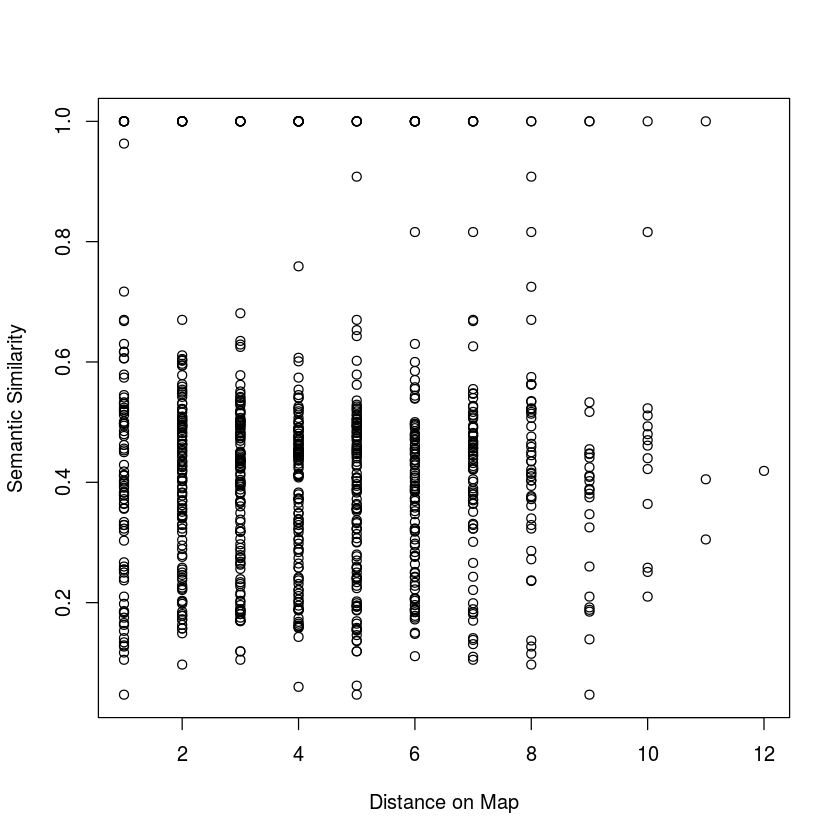

In [25]:
plot(distances, semSims, xlab="Distance on Map", ylab="Semantic Similarity")

In [26]:
cor(distances, semSims)

[1] 0.01009209